In [1]:
from __future__ import print_function

import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


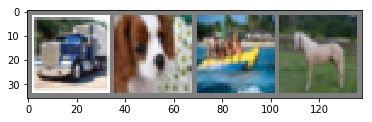

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [6]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda:2


## DenseNet
![DenseNet](http://img.cdn.iblue.tech/image/20190304/PXj7daLTqQA5.png?imageslim)

In [7]:
class Bottleneck(nn.Module):
    """
    Dense Block
    这里的growth_rate=out_channels, 就是每个Block自己输出的通道数。
    先通过1x1卷积层，将通道数缩小为4 * growth_rate，然后再通过3x3卷积层降低到growth_rate。
    """
    expansion = 4
    
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        zip_channels = self.expansion * growth_rate
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(True),
            nn.Conv2d(zip_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.features(x)
        out = torch.cat([out, x], 1)
        return out        

In [8]:
class Transition(nn.Module):
    """
    改变维数的Transition层
    先通过1x1的卷积层减少channels，再通过2x2的平均池化层缩小feature-map
    """
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(2)
        )
        
    def forward(self, x):
        out = self.features(x)
        return out

In [9]:
class DenseNet(nn.Module):
    """
    Dense Net
    paper中growth_rate取12，维度压缩的参数θ，即reduction取0.5
    且初始化方法为kaiming_normal()
    num_blocks为每段网络中的DenseBlock数量
    DenseNet和ResNet一样也是六段式网络（一段卷积+四段Dense+平均池化层），最后FC层。
    第一段将维数从3变到2 * growth_rate
    
    (3, 32, 32) -> [Conv2d] -> (24, 32, 32) -> [layer1] -> (48, 16, 16) -> [layer2]
  ->(96, 8, 8) -> [layer3] -> (192, 4, 4) -> [layer4] -> (384, 4, 4) -> [AvgPool]
  ->(384, 1, 1) -> [Linear] -> (10)
    
    """
    def __init__(self, num_blocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.reduction = reduction
        
        num_channels = 2 * growth_rate
        
        self.features = nn.Conv2d(3, num_channels, kernel_size=3, padding=1, bias=False)
        self.layer1, num_channels = self._make_dense_layer(num_channels, num_blocks[0])
        self.layer2, num_channels = self._make_dense_layer(num_channels, num_blocks[1])
        self.layer3, num_channels = self._make_dense_layer(num_channels, num_blocks[2])
        self.layer4, num_channels = self._make_dense_layer(num_channels, num_blocks[3], transition=False)
        self.avg_pool = nn.Sequential(
            nn.BatchNorm2d(num_channels),
            nn.ReLU(True),
            nn.AvgPool2d(4),
        )
        self.classifier = nn.Linear(num_channels, num_classes)
        
        self._initialize_weight()
        
    def _make_dense_layer(self, in_channels, nblock, transition=True):
        layers = []
        for i in range(nblock):
            layers += [Bottleneck(in_channels, self.growth_rate)]
            in_channels += self.growth_rate
        out_channels = in_channels
        if transition:
            out_channels = int(math.floor(in_channels * self.reduction))
            layers += [Transition(in_channels, out_channels)]
        return nn.Sequential(*layers), out_channels
    
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [10]:
def DenseNet121():
    return DenseNet([6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet([6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet([6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet([6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet([6,12,24,16], growth_rate=12)

In [11]:
net = densenet_cifar().to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

DenseNet(
  (features): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace)
        (5): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace)
        (5): Conv2d(48, 12, kernel_siz

In [12]:
# 测试
x = torch.randn(1, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

torch.Size([1, 10])


In [13]:
lr = 1e-1
momentum = 0.9
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# 论文原文的batch_size设置为64，epoch为300，在训练到50%和75%的epoch的时候，衰减学习率为原先的1/10
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225])

In [19]:
# Training
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    loss = train_loss / batch_idx
    print('Epoch: %d, train loss: %.6f, acc: %.3f%% (%d/%d)' % (epoch, loss, acc, correct, total))
    return loss

In [15]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    loss = test_loss / batch_idx
    print('Epoch: %d, test loss: %.6f, acc: %.3f%% (%d/%d)' % (epoch, loss, acc, correct, total))
    return loss

In [16]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/densenet.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [17]:
def plot_loss(train_losses, test_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(test_losses)), test_losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
train_losses = []
test_losses = []

In [ ]:
for epoch in range(start_epoch, 300):
    scheduler.step()
    train_loss = train(epoch)
    test_loss = test(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    start_epoch = epoch

Epoch: 0, train loss: 1.163450, acc: 58.200% (29100/50000)
Epoch: 0, test loss: 0.997180, acc: 65.310% (6531/10000)
Epoch: 1, train loss: 0.760592, acc: 73.428% (36714/50000)
Epoch: 1, test loss: 0.711551, acc: 75.480% (7548/10000)
Epoch: 2, train loss: 0.603602, acc: 79.096% (39548/50000)
Epoch: 2, test loss: 0.659617, acc: 77.300% (7730/10000)
Epoch: 3, train loss: 0.527196, acc: 81.718% (40859/50000)
Epoch: 3, test loss: 0.709168, acc: 76.320% (7632/10000)
Epoch: 4, train loss: 0.475196, acc: 83.478% (41739/50000)
Epoch: 4, test loss: 0.562845, acc: 80.480% (8048/10000)
Epoch: 5, train loss: 0.434821, acc: 84.848% (42424/50000)
Epoch: 5, test loss: 0.483382, acc: 83.640% (8364/10000)
Epoch: 6, train loss: 0.408296, acc: 85.716% (42858/50000)
Epoch: 6, test loss: 0.473439, acc: 83.720% (8372/10000)
Epoch: 7, train loss: 0.385241, acc: 86.788% (43394/50000)
Epoch: 7, test loss: 0.442325, acc: 84.650% (8465/10000)
Epoch: 8, train loss: 0.367403, acc: 87.112% (43556/50000)
Epoch: 8, tes

Epoch: 70, train loss: 0.190518, acc: 93.348% (46674/50000)
Epoch: 70, test loss: 0.395305, acc: 87.630% (8763/10000)
Epoch: 71, train loss: 0.180591, acc: 93.672% (46836/50000)
Epoch: 71, test loss: 0.397041, acc: 87.480% (8748/10000)
Epoch: 72, train loss: 0.186582, acc: 93.296% (46648/50000)
Epoch: 72, test loss: 0.403386, acc: 87.430% (8743/10000)
Epoch: 73, train loss: 0.177998, acc: 93.672% (46836/50000)
Epoch: 73, test loss: 0.358342, acc: 89.000% (8900/10000)
Epoch: 74, train loss: 0.178711, acc: 93.772% (46886/50000)
Epoch: 74, test loss: 0.414994, acc: 86.800% (8680/10000)
Epoch: 75, train loss: 0.182259, acc: 93.660% (46830/50000)
Epoch: 75, test loss: 0.390513, acc: 87.500% (8750/10000)
Epoch: 76, train loss: 0.179840, acc: 93.656% (46828/50000)
Epoch: 76, test loss: 0.380237, acc: 87.490% (8749/10000)
Epoch: 77, train loss: 0.177745, acc: 93.726% (46863/50000)
Epoch: 77, test loss: 0.407836, acc: 87.260% (8726/10000)
Epoch: 78, train loss: 0.176663, acc: 93.830% (46915/500

Epoch: 140, train loss: 0.155879, acc: 94.494% (47247/50000)
Epoch: 140, test loss: 0.430733, acc: 86.960% (8696/10000)
Epoch: 141, train loss: 0.151579, acc: 94.602% (47301/50000)
Epoch: 141, test loss: 0.395767, acc: 87.710% (8771/10000)
Epoch: 142, train loss: 0.156757, acc: 94.566% (47283/50000)
Epoch: 142, test loss: 0.444177, acc: 86.650% (8665/10000)
Epoch: 143, train loss: 0.148703, acc: 94.826% (47413/50000)
Epoch: 143, test loss: 0.459451, acc: 86.780% (8678/10000)
Epoch: 144, train loss: 0.149935, acc: 94.794% (47397/50000)
Epoch: 144, test loss: 0.378492, acc: 88.170% (8817/10000)
Epoch: 145, train loss: 0.155332, acc: 94.592% (47296/50000)
Epoch: 145, test loss: 0.422908, acc: 87.470% (8747/10000)
Epoch: 146, train loss: 0.155353, acc: 94.492% (47246/50000)
Epoch: 146, test loss: 0.362810, acc: 88.470% (8847/10000)
Epoch: 147, train loss: 0.153319, acc: 94.538% (47269/50000)
Epoch: 147, test loss: 0.385522, acc: 88.000% (8800/10000)
Epoch: 148, train loss: 0.148969, acc: 9

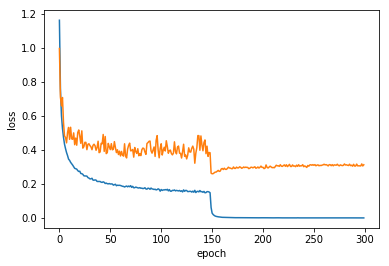

In [21]:
plot_loss(train_losses, test_losses)

In [22]:
save_model = True
if save_model:
    state = {
        'net': net.state_dict(),
        'epoch': epoch,
    }
    os.makedirs('checkpoint', exist_ok=True)
    torch.save(state, './checkpoint/densenet.ckpt')

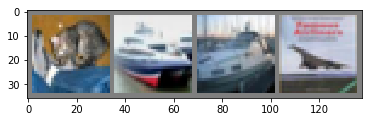

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 92 %
Accuracy of plane : 96 %
Accuracy of   car : 96 %
Accuracy of  bird : 89 %
Accuracy of   cat : 80 %
Accuracy of  deer : 94 %
Accuracy of   dog : 91 %
Accuracy of  frog : 92 %
Accuracy of horse : 93 %
Accuracy of  ship : 98 %
Accuracy of truck : 96 %


In [23]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))